# Experiment with visualisation of heatwave metrics by country 

Aim to produce some intuitive comparison of conditions

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [15]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2020'

# POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
# POPULATION_FILE = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'
# DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2019_PopulationByAgeSex_Medium.csv'
# COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

COUNTRY_SHAPEFILE = Path('~').expanduser() / 'Documents' / 'Lancet'/ 'Standardisation guidelines - LIVE FOR AUTHORS' / 'Shapefiles' / 'detailed_2013.shp'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [9]:
MAP_PROJECTION = ccrs.EckertIII()

## Load basic country data

In [10]:
countries = gpd.read_file(COUNTRY_SHAPEFILE)

In [11]:
# # Some things use the numeric code as an int instead of 0 padded 3 digit code
# countries['iso_n_int'] = countries.iso_n3.str.lstrip('0').astype(int)

In [12]:
countries = countries.set_index('ISO_3_CODE')

## Load the country exposure results

In [16]:
exposure_results = xr.open_dataset(RESULTS_FOLDER / f'countries_heatwaves_exposure_change_1980-{MAX_YEAR}.nc')

In [17]:
exposure_results

<xarray.Dataset>
Dimensions:               (country: 248, year: 40)
Coordinates:
  * year                  (year) int64 1980 1981 1982 1983 ... 2017 2018 2019
  * country               (country) object 'AFG' 'ALB' 'DZA' ... 'UMI' 'KOS'
Data variables:
    heatwave_degrees      (country, year) float64 ...
    heatwave_mean_length  (country, year) float64 ...
    heatwaves_counts      (country, year) float64 ...
    heatwaves_days        (country, year) float64 ...
    heatwaves_deg_days    (country, year) float64 ...

## Load country weighted mean heatwave

In [18]:
weighted_results = xr.open_dataset(RESULTS_FOLDER / f'countries_heatwaves_exposure_weighted_change_1980-{MAX_YEAR}.nc')

In [19]:
weighted_results

<xarray.Dataset>
Dimensions:               (country: 248, year: 40)
Coordinates:
  * year                  (year) int64 1980 1981 1982 1983 ... 2017 2018 2019
  * country               (country) object 'AFG' 'ALB' 'DZA' ... 'UMI' 'KOS'
Data variables:
    heatwave_degrees      (country, year) float64 ...
    heatwave_mean_length  (country, year) float64 ...
    heatwaves_counts      (country, year) float64 ...
    heatwaves_days        (country, year) float64 ...
    heatwaves_deg_days    (country, year) float64 ...

# Load country population data

In [20]:
wpp_population = pd.read_csv(UN_DEMOGRAPHICS_FILE)

In [21]:
wpp_population

LocID     Location  VarID Variant  Time  MidPeriod AgeGrp  \
0           4  Afghanistan      2  Medium  1950     1950.5    0-4   
1           4  Afghanistan      2  Medium  1950     1950.5    5-9   
2           4  Afghanistan      2  Medium  1950     1950.5  10-14   
3           4  Afghanistan      2  Medium  1950     1950.5  15-19   
4           4  Afghanistan      2  Medium  1950     1950.5  20-24   
...       ...          ...    ...     ...   ...        ...    ...   
795916    716     Zimbabwe      2  Medium  2100     2100.5  80-84   
795917    716     Zimbabwe      2  Medium  2100     2100.5  85-89   
795918    716     Zimbabwe      2  Medium  2100     2100.5  90-94   
795919    716     Zimbabwe      2  Medium  2100     2100.5  95-99   
795920    716     Zimbabwe      2  Medium  2100     2100.5   100+   

        AgeGrpStart  AgeGrpSpan  PopMale  PopFemale  PopTotal  
0                 0           5  630.044    661.578  1291.622  
1                 5           5  516.206    487.335  1003.540  
2                10           5  461.378    423.326   884.704  
3                15           5  414.369    369.363   783.732  
4                20           5  374.109    318.392   692.501  
...             ...         ...      ...        ...       ...  
795916           80           5  265.750    419.683   685.433  
795917           85           5  127.913    248.914   376.828  
795918           90           5   30.277     78.801   109.077  
795919           95           5    3.581     13.659    17.240  
795920          100          -1    0.204      1.203     1.407  

[795921 rows x 12 columns]

In [22]:
# countries

In [23]:
# wpp_population['iso_a3'] = wpp_population.LocID.replace(countries.reset_index().set_index('iso_n_int')['iso_a3'])

In [24]:
# Drop non-country codes ( >= 900)
wpp_population = wpp_population[wpp_population.LocID < 900].copy()

In [25]:
len(wpp_population.LocID.unique())

201

In [26]:
# wpp_population.loc[wpp_population.iso_a3 == wpp_population.LocID, 'iso_a3'] = None

In [20]:
# countries_population_2018 = wpp_population[wpp_population.Time==2018].groupby('iso_a3').PopTotal.sum()

## Load the country health data

In [21]:
# health_data = pd.read_csv('country_health_data.csv')

In [22]:
# countries_population_2018 = health_data.join(countries_population_2018, on='DisplayValue')

# Rank the countries by exposure and mean weighted exposures
# TODO repeat of total exposure plot but instead make a stacked plot with the countries. Focus on Days of heatwave because I think people will be confused by degree-days and degrees.

In [23]:
# var = 'heatwaves_counts'
# # Sort and show the top 5 for a given year
# exposure_results[var].sel(year=2018).to_dataframe().sort_values(by=var, ascending=False).head(10)[var].plot.bar()

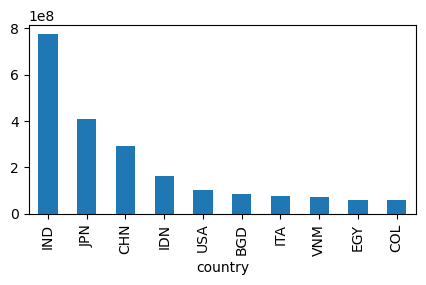

In [27]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
exposure_results[var].sel(year=MAX_YEAR).to_dataframe().sort_values(by=var, ascending=False).head(10)[var].plot.bar()

# Plot exposures as a stacked graph highlighting the main countries/regions

Get a rough calculation of the 'top' countries using the latest 10 year average (not just the last year to make it a bit fair)

In [25]:
exposures = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_1980-{MAX_YEAR}.nc')

In [26]:
total_exposure_days = exposures.heatwaves_days.sum(dim=['latitude', 'longitude']).to_dataframe('exposures')

In [27]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
top_codes = exposure_results[var].sel(year=slice(2000,2019)).mean(dim='year').to_dataframe().sort_values(by=var, ascending=False).head(5)[var].index.to_list()

results = exposure_results[var].sel(country=top_codes).to_dataframe()[var].unstack().T
# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = total_exposure_days.exposures - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

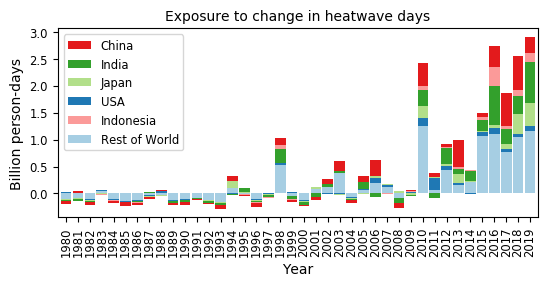

In [44]:
with sns.color_palette("Paired"):
    f, ax = plt.subplots(figsize=(6.2, 2.5))
    (results / 1e9).plot.bar(stacked=True, 
                                  width=0.9, 
                                  label='Change relative to recent past average',
                             ax=ax
                            )
# plt.rcParams['figure.titlesize'] = 'medium'
# plt.rcParams['axes.titlesize'] = 'medium'
    ax.set(
        xlabel='Year',
        ylabel='Billion person-days',
        title='Exposure to change in heatwave days',
    )
    ax.xaxis.set_tick_params(labelsize='small')
    ax.yaxis.set_tick_params(labelsize='small')
#     ax.yaxis.label.set(size='medium')
    
    # Manually order the legend
    handles, labels = ax.get_legend_handles_labels()
    d = dict(zip(labels, handles))
    ordered_labels = ['China', 'India', 'Japan', 'USA', 'Indonesia', 'Rest of World']
    iso_codes = ['CHN', 'IND', 'JPN', 'USA', 'IDN', 'Other']

    ordered_handles = [d[l] for l in iso_codes]
    ax.legend(ordered_handles, ordered_labels, fontsize='small')

    f.savefig(RESULTS_FOLDER / f'hw_exposure_days_countries_1980-{MAX_YEAR}.png')
    f.savefig(RESULTS_FOLDER / f'hw_exposure_days_countries_1980-{MAX_YEAR}.pdf')


In [41]:
exp_rolling = exposure_results[var].rolling({'year':10}, center=True).mean().to_dataframe(var)[var].unstack().T.dropna()

In [43]:
tot_rolling = total_exposure_days.rolling(10, center=True).mean().dropna()

In [35]:
plot_data = exp_rolling[top_codes].copy()

plot_data['Other'] = tot_rolling.exposures - plot_data.sum(axis=1)
# invert column order
plot_data = plot_data[plot_data.columns[::-1]]

NameError: name 'exp_rolling' is not defined

In [34]:
# results = exposure_results[var].sel(country=top_codes).to_dataframe()[var].unstack().T
with sns.color_palette("Paired"):
    ax = (plot_data / 1e9).plot.bar(stacked=True, 
                                  width=0.9, 
                                  label='Change relative to recent past average')
    f = ax.figure
    f.set(figsize=(6.5, 2.5))
# plt.rcParams['figure.titlesize'] = 'medium'
# plt.rcParams['axes.titlesize'] = 'medium'
    ax.set(
        xlabel='Year',
        ylabel='Billion person-days',
        title='Exposure to change in heatwave days, 10 year moving average'
    )
    ax.xaxis.set_tick_params(labelsize='small')
    
    # Manually order the legend
    handles, labels = ax.get_legend_handles_labels()
    d = dict(zip(labels,handles))
    ordered_labels = ['CHN', 'IND', 'JPN', 'USA', 'IDN', 'Other']
    ordered_handles = [d[l] for l in ordered_labels]
    ax.legend(ordered_handles, ordered_labels)

    f.savefig(RESULTS_FOLDER / f'hw_exposure_days_rolling_countries_1980-{MAX_YEAR}.png')
    f.savefig(RESULTS_FOLDER / f'hw_exposure_days_rolling_countries_1980-{MAX_YEAR}.pdf')


NameError: name 'plot_data' is not defined

In [167]:
results.loc[2018] / 1e6

country
Other    1039.351164
USA        63.111275
JPN       352.792795
IND       345.593023
IDN        95.455001
CHN       644.812294
Name: 2018, dtype: float64

In [172]:
(plot_data.loc[2014] / 1e6).to_frame().T

country       Other        IDN        USA        JPN         IND         CHN
2014     609.448948  72.114951  77.201559  96.937203  227.049546  280.985446

# Map plots

Try mapping chloropleths with exposures (or weighted exposures) could be a good way to visualise

In [46]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf

In [47]:
# hv.extension('bokeh','matplotlib')
hv.extension('matplotlib')
hv.output(dpi=120)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [48]:
slc = slice(2000, 2019)
decade_mean_expo = exposure_results.sel(year=slc).mean(dim='year')

decade_mean_weight = weighted_results.sel(year=slc).mean(dim='year')

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [51]:
countries_exposures = countries.join(decade_mean_expo.to_dataframe())
countries_weighted = countries.join(decade_mean_weight.to_dataframe())

In [42]:
hw_days_poly = gv.Polygons(countries_exposures, 
                           vdims=[('heatwaves_days', 'Heatwave person-days'), ('name', 'Country')])

hw_days_poly = hw_days_poly.opts(
    title='Exposures to change in heatwave days',
    projection=crs.Robinson(),
    cmap='plasma', 
    colorbar=True, 
    clim=(0, 1e8),
    fig_inches=6,
    linewidth = 0.5,
)
gv.save(hw_days_poly, RESULTS_FOLDER / 'map_days_expo.png', dpi=600)
hw_days_poly

In [212]:
options = dict(fig_inches=6,
    projection=crs.Robinson(),
    cmap='RdBu_r', 
    colorbar=True,
    symmetric=True,
    linewidth = 0.5,
              )

# Decadal averages

These can be the main results - decadal averages are pretty well accepted as a summary stat (I think). Note that it could be nicer even to do window average - this gives then a value for each year and avoids any accidental 'window' effects with the relatively short time series. But it makes it a pain to plot, decade averages gives a neat summary with just 4 maps.

In [52]:
var = 'heatwaves_days'
# Calculate decade average tables and save in a dict
decades = [(1980, 1990), (1990, 2000), (2000,2010), (2010, 2020)]

res_exp = {}
for d in decades:
    decade_mean_weight = exposure_results.sel(year=slice(*d) ).mean(dim='year')
    result = countries.join(decade_mean_weight.to_dataframe())
    result = result[~result.heatwaves_days.isna()]
    res_exp[d]=result

In [53]:
# Calculate decade average tables and save in a dict
decades = [(1980, 1990), (1990, 2000), (2000,2010), (2010, 2020)]

res = {}
for d in decades:
    decade_mean_weight = weighted_results.sel(year=slice(*d) ).mean(dim='year')
    result = countries.join(decade_mean_weight.to_dataframe())
    result = result[~result.heatwaves_days.isna()]
    res[d] = result

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [57]:
# Plot countries with more than a week change in the last decade
t = res[decades[-1]]
t = t[t.heatwaves_days >= 7]
t.sort_values('heatwaves_days', ascending=False)[['SOVEREIGN', 'heatwaves_days']].head(10)

SOVEREIGN  heatwaves_days
BTN    Bhutan       14.066327
EGY     Egypt       12.186737
JAM   Jamaica       10.831837
ISR    Israel        9.543919
YEM     Yemen        7.766090

In [58]:
map_opts = dict(
    projection=MAP_PROJECTION,
    cmap='RdBu_r', 
    colorbar=True,
    symmetric=True,
    linewidth = 0.3,
              )

In [62]:
polys = [gv.Polygons(t, vdims=[('heatwaves_days', '[days]'), ('SOVEREIGN', 'Country')], label=f'{d[0]}-{d[1]-1}').opts( clim=(-5,5), **map_opts)
         for d, t in res.items()]

layout = gv.Layout(polys)

:Layout
   .Polygons.A_1980_hyphen_minus_1989 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
   .Polygons.A_1990_hyphen_minus_1999 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
   .Polygons.A_2000_hyphen_minus_2009 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
   .Polygons.A_2010_hyphen_minus_2019 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
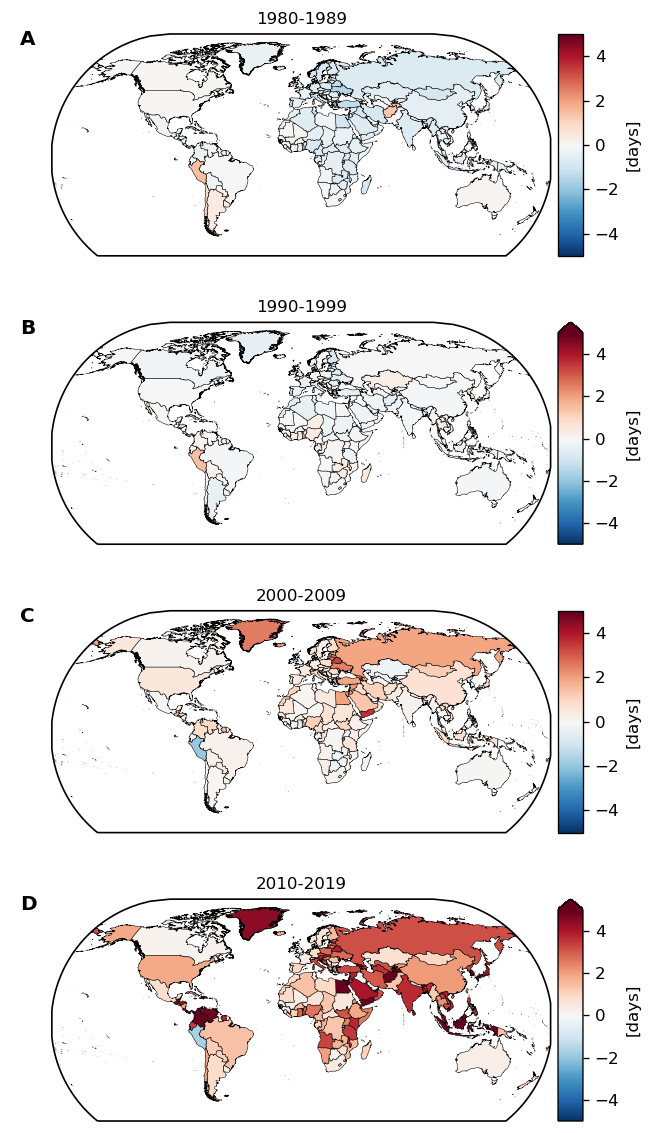

In [63]:
layout.cols(1).opts(fig_inches=6.2, sublabel_position=(-0.1, 0.85), sublabel_size=12)

In [64]:
gv.save(layout, RESULTS_FOLDER / 'decadal_mean_hw_days_tall.png', dpi=600)

:Layout
   .Polygons.A_1980_hyphen_minus_1989 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
   .Polygons.A_1990_hyphen_minus_1999 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
   .Polygons.A_2000_hyphen_minus_2009 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
   .Polygons.A_2010_hyphen_minus_2019 :Polygons   [Longitude,Latitude]   (heatwaves_days,SOVEREIGN)
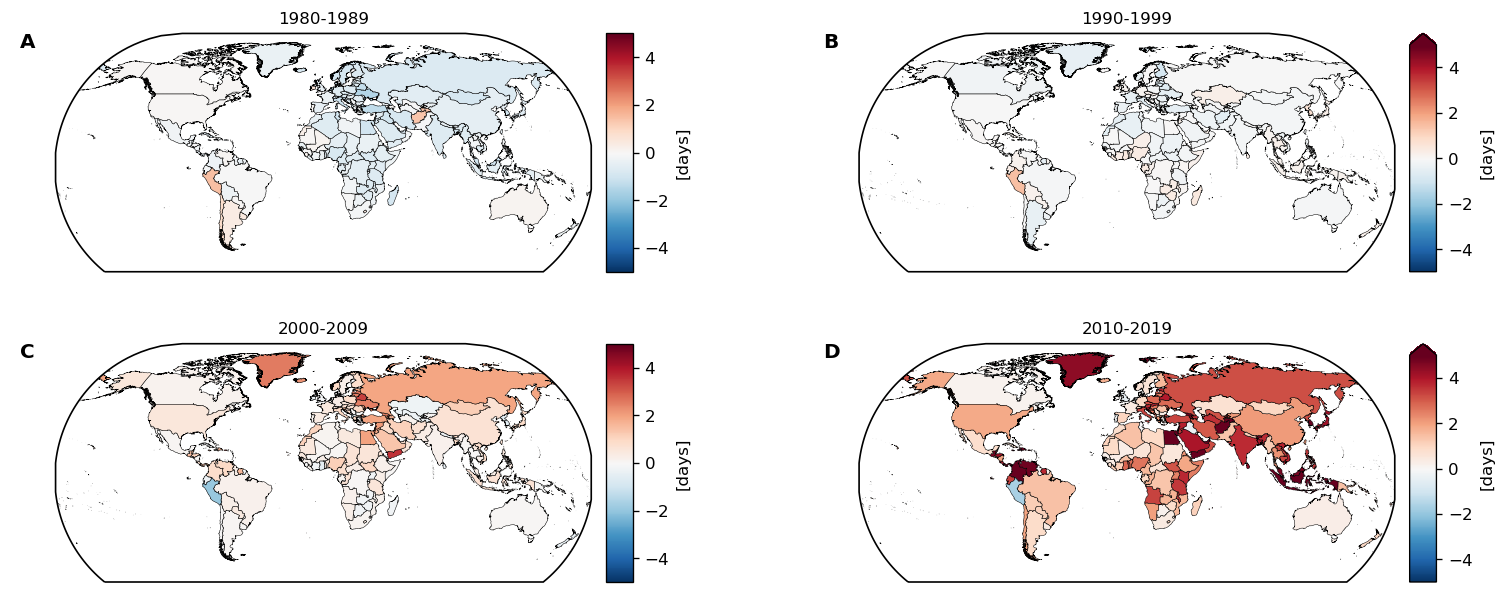

In [65]:
# Alternative 2x2 layout
layout = layout.cols(2)
gv.save(layout, RESULTS_FOLDER / 'decadal_mean_hw_days.png', dpi=600)

layout

# Save animation

Maybe try with decade rolling mean to get more frames - otherwise just 4 frames not that exciing :/

In [49]:
weigh_rolling = weighted_results[var].rolling({'year':10}, center=True).mean().to_dataframe(var)[var].unstack()

In [56]:
res = {}
for y in weigh_rolling:
    decade_mean_weight = weigh_rolling[y]
    decade_mean_weight.name = 'heatwaves_days'
    result = countries.join(decade_mean_weight)
    result = result[~result.heatwaves_days.isna()]
    if len(result) > 0:
        res[y] = result

In [58]:
maps_hm = gv.HoloMap({y: gv.Polygons(t, vdims=[('heatwaves_days', '[days]'), ('name', 'Country')], label=f'{y-5}-{y+5}').opts( clim=(-5,5), **map_opts)
         for y, t in res.items()})

In [61]:
hv.save(maps_hm, 'decade_moving_means.mp4', holomap='mp4', fps=1)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '480x480', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpr01uq_5g.mp4']


In [ ]:
maps_hm

# Tabulate results

Actually best to export and use excel sparklines

In [149]:
country_decade_summary_exp = pd.DataFrame({k: d.set_index('admin')['heatwaves_days'] for k,d in res_exp.items()})

In [150]:
country_decade_summary_weight = pd.DataFrame({k: d.set_index('admin')['heatwaves_days'] for k,d in res.items()})

In [156]:
country_decade_summary_exp = exp_country_decade_summary.sort_index()

In [157]:
country_decade_summary_weight = weigh_country_decade_summary.sort_index()

In [158]:
country_decade_summary_exp.to_excel(RESULTS_FOLDER / 'country_decade_summary_exp.xlsx')

In [159]:
country_decade_summary_weight.to_excel(RESULTS_FOLDER / 'country_decade_summary_weight.xlsx')